# Differentiable FIR Filters

In this chapter, we will implement differentiable FIR filters in three ways, and optimise their parameters.

First, we will highlight the connection between FIR filters and one dimensional convolutional neural network layers, by showing that we can directly optimise a filter by simply convolving a signal with its impulse response.

Secondly, we will introduce a parametric form for FIR filters using windowed-sinc design, and show that this allows us to optimise interpretible parameters such as filter cutoff frequency.

Finally, we show how the linear phase window design method allows us to optimise the frequency response of our filter, and using the FFT convolution algorithm we implement a time-varying filtered noise synthesiser.

To start, we make a few imports...

In [380]:
from typing import Callable, Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

...set some useful globals, seed the PRNG...

In [352]:
SAMPLE_RATE = 16000
EPSILON = 1e-7

SEED = 420
np.random.seed(SEED)
torch.manual_seed(SEED)

...and define some utility functions.

In [353]:
def safe_log(x: Union[np.ndarray, torch.Tensor], base: Optional[float] = None, eps: float = EPSILON):
    if isinstance(x, np.ndarray):
        denom = 1 if base is None else np.log(base)
        return np.log(np.clip(x, eps, None)) / denom
    elif isinstance(x, torch.Tensor):
        denom = 1 if base is None else torch.log(base)
        return torch.log(torch.clamp(x, min=eps)) / denom

## `nn.Conv1D` $\approx$ FIR

As we have discussed, applying a discrete time FIR filter to a signal is equivalent to convolving the signal $x[n]$ with the impulse response of the filter $h[n]$:

$$
y[n] = (x\ast h)[n] = \sum_{m=-\infty}^\infty x[n-m]h[m].
$$

Of course, neither our impulse response nor our signal is infinitely long, meaning they are implicitly padded by zeros and we can truncate the sum. Let us assume that our impulse response has length $M$, then our signal $y[n]$ is given by:

$$
y[n] = \sum_{m=0}^M x[n-m]h[m].
$$

This, you might notice, is very close to the way that 1D convolutional layers are computed in neural networks\*. So close, in fact, that convolutional layers effectively _are_ differentiable FIR filters!

\* Confusingly, these layers perform *cross-correlation* instead of convolution, which is very similar but the impulse response (which, in this context, is referred to as a kernel) is reversed. In fact, if we swap $x[n-m]$ for $x[n+m]$, we have a 1D convolutional layer.

Let's start by exploring this connection a little and creating some very simple FIR filters. We start by creating a white noise signal $x$ of length $N$, but first let's write a function to help us plot signals.

In [354]:
def plot_signal_and_spectrum(signal: torch.Tensor):
    """We'll be wanting to plot some signals, so let's make that nice and easy...
    """
    signal = signal.detach().numpy()

    # compute the log magnitude spectrum of the signal
    spectrum = np.fft.rfft(signal, norm="forward")
    spectrum = np.abs(spectrum)
    spectrum = 20 * safe_log(spectrum, 10)

    fig, ax = plt.subplots(2, 1, figsize=(6, 4))
    t = np.arange(signal.size) / SAMPLE_RATE
    ax[0].plot(t, signal, color="black", linewidth=0.5)
    ax[0].set_title("Signal")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_ylabel("Amplitude")

    f = SAMPLE_RATE * np.arange(signal.size // 2 + 1) / signal.size
    ax[1].plot(f, spectrum, color="black", linewidth=0.5)
    ax[1].set_xscale("log")
    ax[1].set_title("Spectrum")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_ylabel("Magnitude (dB)")

    fig.tight_layout()

And now we create and visualise the signal:

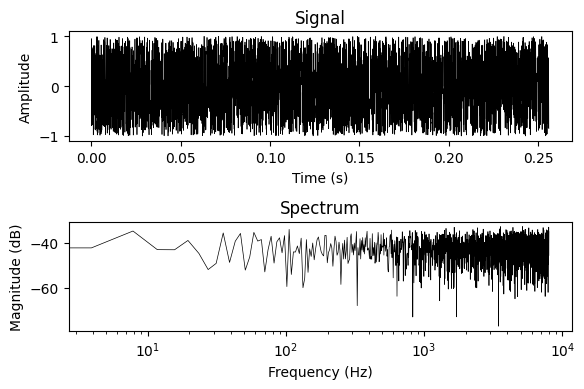

In [355]:
N = 4096
x = torch.empty(N).uniform_(-1, 1)
plot_signal_and_spectrum(x)

Now let's create a very simple filter, the one given by the difference equation:

$$
y[n] = x[n] + x[n-1] + x[n-2].
$$

This is a simple moving average filter, which attenuates the high frequencies. It is equivalent to the impulse response: $\mathbf{h} = \begin{bmatrix}1 & 1 & 1\end{bmatrix}^T$.

Again, we first create a helper function to plot the filter response as a Bode plot.

In [356]:
BODE_PLOT_COLORS = ["black", "red", "green", "blue", "orange"]
BODE_PLOT_LINESTYLES = ["solid", "dashed", "dotted", "dashdot"]

def bode_plot(
    impulse_response: Union[torch.Tensor, list[torch.Tensor]],
    N: int,
    labels: Optional[list[str]] = None
):
    """We'll be wanting to look at some filters too... so let's make some Bode plots
    """

    if not isinstance(impulse_response, list):
        impulse_response = [impulse_response]
    hs = [i.detach().numpy() for i in impulse_response]

    # evaluate the z-transform at roots of unity by zero padding the impulse
    # response and taking the DFT
    hs_ = [np.pad(h, (0, N - h.size)) for h in hs]
    Hs = [np.fft.rfft(h_)[:-1] for h_ in hs_]
    
    H_mags = [np.abs(H) for H in Hs]
    H_mags = [20 * safe_log(H_mag, 10) for H_mag in H_mags]
    
    H_phases = [np.angle(H) for H in Hs]

    fig, ax = plt.subplots(3, 1, figsize=(6, 6))
    f = SAMPLE_RATE * np.arange(N // 2) / N

    if labels is None:
        labels = [None] * len(hs)
    
    for H_mag, H_phase, h, label, color, linestyle in zip(
        H_mags, H_phases, hs, labels, BODE_PLOT_COLORS, BODE_PLOT_LINESTYLES
    ):
        ax[0].plot(f, H_mag, linewidth=1.0, label=label, color=color, linestyle=linestyle)
        ax[0].set_xscale("log")
        ax[0].set_title("Magnitude")
        ax[0].set_xlabel("Frequency (Hz)")
        ax[0].set_ylabel("dB")
        
        ax[1].plot(f, H_phase, linewidth=1.0, label=label, color=color, linestyle=linestyle)
        ax[1].set_xscale("log")
        ax[1].set_title("Phase")
        ax[1].set_xlabel("Frequency (Hz)")
        ax[1].set_ylabel("radians")
        
        _, stem, _ = ax[2].stem(h, basefmt="black", label=label, linefmt=color)
        plt.setp(stem, "linewidth", 1.0)
        plt.setp(stem, "linestyle", linestyle)
        ax[2].set_title("Impulse Response")
        ax[2].set_xlabel("Sample Index")
        ax[2].set_ylabel("Amplitude")
        fig.tight_layout()

    if any([l is not None for l in labels]):
        ax[0].legend()

And then we define our filter...

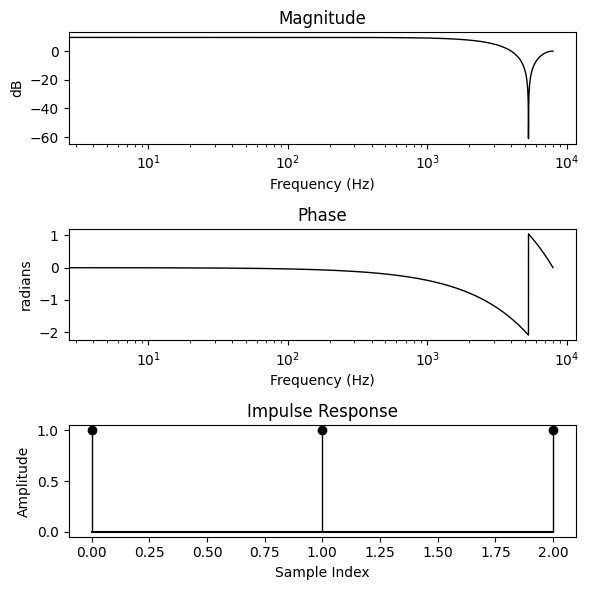

In [357]:
h = torch.tensor([1.0, 1.0, 1.0])

bode_plot(h, N)

We will now use PyTorch's `nn.functional.conv1d` to apply our impulse response (aka kernel) to our signal. Note that [this function expects](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv1d.html) an input tensor with the shape `[batch, in_channels, time]`, and a kernel tensor with shape `[out_channels, in_channels, length]`. Now, as we are operating with a batch size of 1, and on only a single channel, we will just add placeholder dimensions.

In [358]:
x_ = x[None, None, :]  # unsqueeze to [batch, in_channels, time]
h_ = h[None, None, :]  # unsqueeze to [out_channels, in_channels, length]

print(f"input shape: {x_.shape}\nkernel shape: {h_.shape}")

input shape: torch.Size([1, 1, 4096])
kernel shape: torch.Size([1, 1, 3])


Our tensors are correctly shaped... let's perform the convolution! Note that we call `torch.Tensor.flip()` in order to reverse the impulse response. This makes the `nn.functional.conv1d`'s cross-corelation operation into a convolution. We also pad the signal *causally*, rather than relying on PyTorch's `same` padding.

In [359]:
x_padded = nn.functional.pad(x_, (h_.shape[-1] - 1, 0))
y_ = nn.functional.conv1d(
    x_padded,
    h_.flip(-1),
    padding="same"
)
y = y_.squeeze()

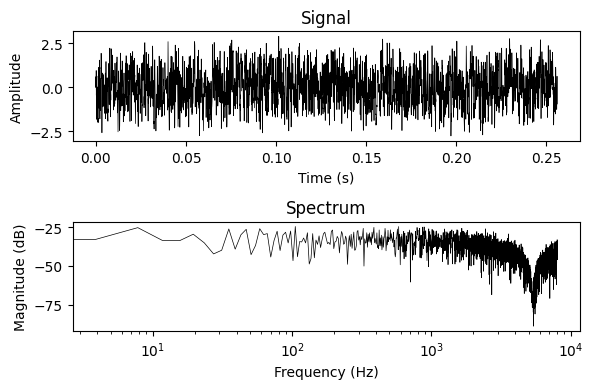

In [360]:
plot_signal_and_spectrum(y)

### Optimising our simple FIR filter

Now, let's try to optimise the impulse response of our direct convolution filter so that it matches a target filter's response. To do so, let's first wrap our filtering code in a nice tidy function:

In [361]:
@torch.jit.script
def apply_conv1d_fir(input_signal: torch.Tensor, impulse_response: torch.Tensor):
    input_signal = nn.functional.pad(input_signal, (impulse_response.shape[-1] - 1, 0))
    input_signal = input_signal[None, None, :]  # unsqueeze to [batch, in_channels, time]
    impulse_response = impulse_response[None, None, :]  # unsqueeze to [out_channels, in_channels, length]
    output_signal = nn.functional.conv1d(
        input_signal,
        impulse_response.flip(-1),
    )
    return output_signal.squeeze()

We then define our predicted filter's impulse response as a tensor. Note that we set `requires_grad=True`. This ensures that PyTorch records operations on this tensor in its computation graph so that we can perform backpropogation to recover its gradient.

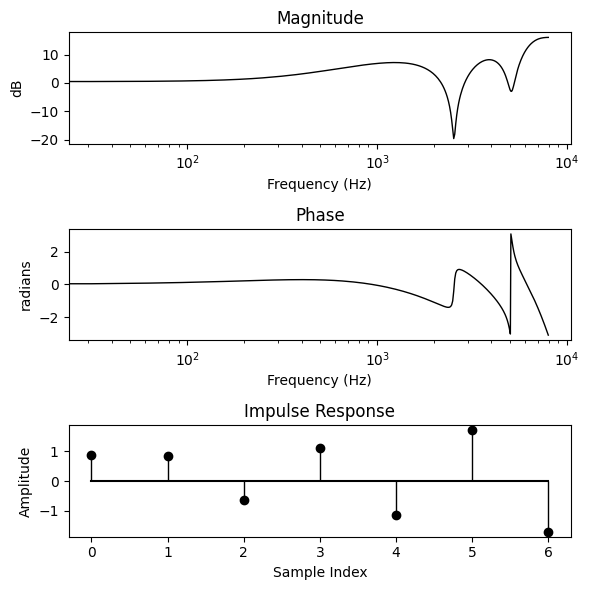

In [362]:
N = 512
M = 7
predicted_impulse_response = torch.randn(M, requires_grad=True)

bode_plot(predicted_impulse_response, N)

We define a synthetic target signal by creating a target filter... Let's make it something very obvious, alternating 1s and -1s.

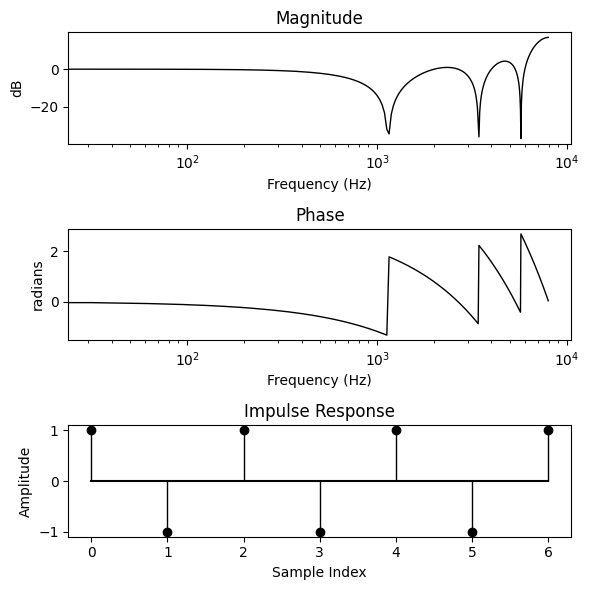

In [363]:
target_filter = torch.Tensor([1, -1, 1, -1, 1, -1, 1])
bode_plot(target_filter, N)

We define our target signal by applying the filter to some white noise.

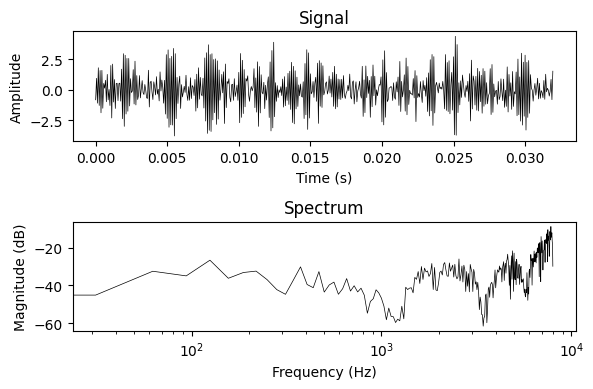

In [364]:
input_signal = torch.empty(N).uniform_(-1, 1)
target_signal = apply_conv1d_fir(input_signal, target_filter)

plot_signal_and_spectrum(target_signal)

Now we write a simple optimisation loop. Note that we are *applying the filter* to the noise signal in order to compute our loss. We are then taking a loss function between our target signal and the noise signal filtered by our predicted filter. This means there's no reason that we need to use $L^2$ loss --- we can use *any* loss function we can define on the signal.

In [365]:
optimizer = torch.optim.Adam([predicted_impulse_response], lr=1e-3)
criterion = nn.MSELoss()

steps = 7000
interval = 1000

for step in range(steps):
    predicted_signal = apply_conv1d_fir(input_signal, predicted_impulse_response)
    loss = criterion(target_signal, predicted_signal)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if step % interval == 0:
        print(f"Step {step}: loss {loss.item():.4f}")

Step 0: loss 9.8862
Step 1000: loss 3.6374
Step 2000: loss 1.0242
Step 3000: loss 0.1884
Step 4000: loss 0.0172
Step 5000: loss 0.0004
Step 6000: loss 0.0000


Cool! That converged quickly. Let's plot the learnt response...

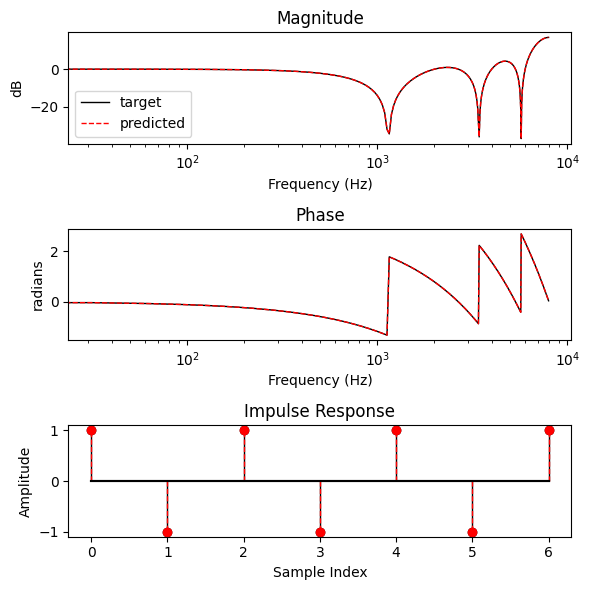

In [366]:
bode_plot([target_filter, predicted_impulse_response], N, labels=["target", "predicted"])

A perfect fit!

## FFT Convolution

For longer impulse responses, the quadratic time complexity of naive convolution becomes a bottleneck, and so efficient convolution algorithms are often preferred. Perhaps the best known is FFT convolution, which is a result of the discrete convolution theorem — the discrete Fourier transform of the circular convolution of two periodic signals is equal to the element-wise product of the Fourier transforms of the individual signals:

$$
\mathcal{F}\{u\ast v\}[k] = \mathcal{F}\{u\}[k] \cdot \mathcal{F}\{v\}[k]
$$

Computationally, this allows us to perform convolution in $\mathcal{O}(n\log n)$ time in lieu of $\mathcal{O}(n^2)$. Let's try implementing it.

In [367]:
@torch.jit.script
def apply_fft_fir(input_signal: torch.Tensor, impulse_response: torch.Tensor):
    N = input_signal.shape[-1]
    L = impulse_response.shape[-1]
    
    input_signal = nn.functional.pad(input_signal, (0, L - 1))
    impulse_response = nn.functional.pad(impulse_response, (0, N - 1))

    X = torch.fft.rfft(input_signal)
    H = torch.fft.rfft(impulse_response)
    y = torch.fft.irfft(X * H)

    return y[:-(L - 1)]

Notice that we zero pad the lengths of the input signal (starting length $N$) and the impulse response (starting length $L$) to $N+L-1$. This is because frequency domain multiplication is equivalent to *circular* convolution. The zero padding is hence necessary to avoid the tail of the convolved signal "wrapping" to the start.

Now let's apply it to a signal...

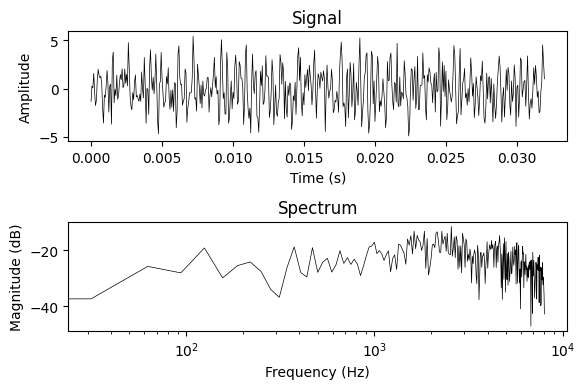

In [368]:
h = torch.randn(11)
y = apply_fft_fir(input_signal, h)
plot_signal_and_spectrum(y)

...and compare to our time-domain implementation:

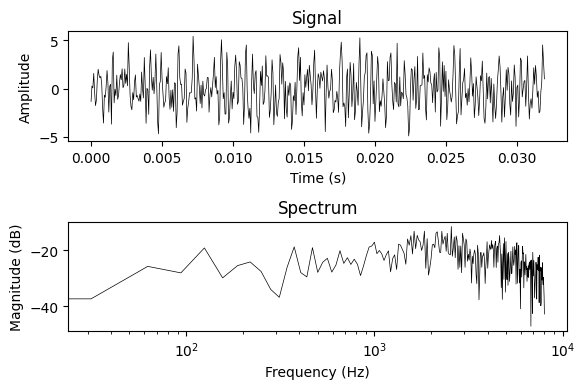

In [369]:
y_ = apply_conv1d_fir(input_signal, h)
plot_signal_and_spectrum(y_)

Looks close! Let's check the error...

In [370]:
mse = (y - y_).square().mean().item()
print(f"Mean squared error between nn.functional.conv1d and FFT convolution is: {mse}")

Mean squared error between nn.functional.conv1d and FFT convolution is: 2.0662443110663897e-13


The question is... is it really faster than directly applying the convolution? Let's run a small experiment to find out...

IR length L = 4: FFT time 0.306, Conv1D time 0.056
IR length L = 8: FFT time 0.376, Conv1D time 0.098
IR length L = 16: FFT time 0.372, Conv1D time 0.157
IR length L = 32: FFT time 0.458, Conv1D time 0.080
IR length L = 64: FFT time 0.344, Conv1D time 0.075
IR length L = 128: FFT time 0.344, Conv1D time 0.099
IR length L = 256: FFT time 0.417, Conv1D time 0.251
IR length L = 512: FFT time 0.481, Conv1D time 0.241
IR length L = 1024: FFT time 0.947, Conv1D time 0.720
IR length L = 2048: FFT time 0.999, Conv1D time 2.150
IR length L = 4096: FFT time 1.442, Conv1D time 4.426
IR length L = 8192: FFT time 3.580, Conv1D time 8.401


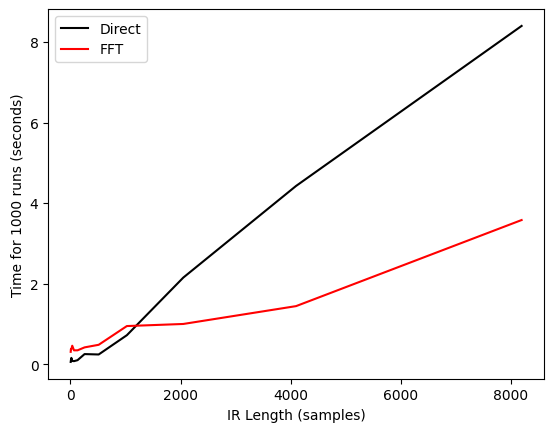

In [371]:
from timeit import timeit

n_trials = 1000

N = 1024
x = torch.empty(N)

ir_sizes = [2 ** n for n in range(2, 14)]
fft_times = []
conv1d_times = []

for ir_size in ir_sizes:
    h = torch.empty(ir_size)

    fft_time = timeit(lambda: apply_fft_fir(x, h), number=n_trials)
    conv1d_time = timeit(lambda: apply_conv1d_fir(x, h), number=n_trials)

    fft_times.append(fft_time)
    conv1d_times.append(conv1d_time)

    print(f"IR length L = {ir_size}: FFT time {fft_time:.3f}, Conv1D time {conv1d_time:.3f}")

plt.plot(ir_sizes, conv1d_times, color="black", label="Direct")
plt.plot(ir_sizes, fft_times, color="red", label="FFT")
plt.ylabel(f"Time for {n_trials} runs (seconds)")
plt.xlabel("IR Length (samples)")
plt.legend()

As expected, for larger impulse responses FFT convolution is clearly faster. But interestingly, for responses below roughly 1000 samples, the direct convolution approach wins out.

There are a number of factors at play here, and to detail them all would be well beyond the scope of this tutorial. However, it suffices to acknowledge a few points:

1. This is a single implementation being tested under unscientific conditions on a particular CPU.
2. Convolutions are conditionally dispatched to different MKLDNN (CPU) and cuDNN (GPU) kernels depending on various factors including kernel size. These include other fast-convolution algorithms such as Winograd.
3. We can expect a bigger relative speed up for FFT convolutions on a GPU thanks to hardware-level parallelisation of matrix multiplications.

For more background, and a performance comparison of cuDNN convolution algorithms, see the work of Jordà et al. {cite}`jorda_performance_2019`.

## Linear Phase Filter Design by Frequency Sampling

While we can directly optimise the impulse response, we may find when predicting impulse responses with a neural network that small errors result in undesirable frequency domain artefacts due to spectral leakage. We also may not be concerned with directly modelling the phase response. Further, we may simply wish to have a more interpetible intermediate filter representation, allowing for regularisation or weighting of specific frequency bands.

To address these needs, we turn to the classical signal processing toolbox and adopt the frequency sampling method for linear phase FIR filters. The first differentiable implementation of this method was provided by Engel, et al. {cite}`engel_ddsp_2020`, who used it in combination with a harmonic sinusoidal model to create a differentiable harmonic-plus-noise synthesiser.

The design process works as follows. The target magnitude response is given as a vector $\mathbf{H}^\ast$ of *samples* from the desired frequency response, taken at the frequencies of a discrete Fourier transform.

We take the inverse discrete Fourier transform of the impulse response (denoted below as the Hermitian transpose,  $\cdot^H$, of the period $N$ discrete Fourier matrix, $W_N^H$). The resulting signal is a zero phase FIR filter, and is hence non-causal. Due to the periodicity of the DFT, we can shift it to causal form with a circular shift, which we denote below by the matrix $C$. Finally, we apply a window function. This helps suppress spectral leakage, at the expense of a wider main lobe.

$$
\begin{array}{rlr}
\mathbf{h}^\ast &= \mathbf{W}_N^H \mathbf{H}^\ast & \text{(magnitude response }\mapsto\text{ impulse response)} \\
\mathbf{h}_s &= \mathbf{C} \mathbf{h}^\ast & \text{(circular shift of }\left\lfloor\frac{M}{2}\right\rfloor \text{)} 
 \\
\mathbf{h} &= \text{diag}(\mathbf{w}) \mathbf{h}_s & \text{(apply window function)} \\
\end{array}
$$

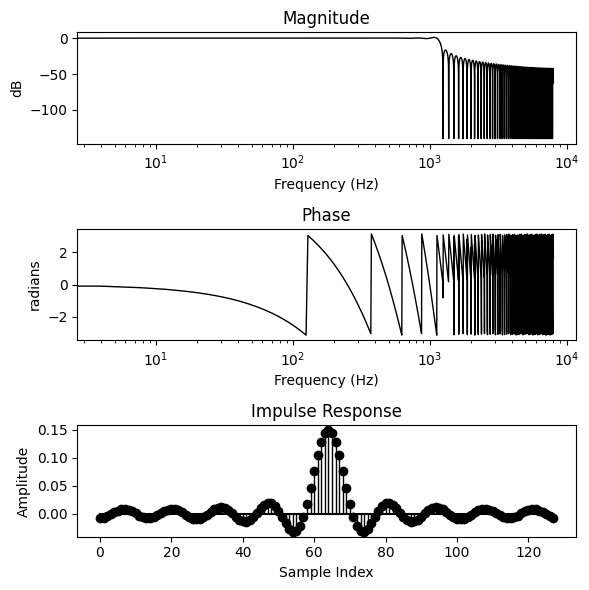

In [543]:
ir_length = 128

H_target = torch.cat((
    torch.ones(10),
    torch.zeros(ir_length // 2 + 1 - 10),
))
h_zero_phase = torch.fft.irfft(H_target)
h_s = torch.roll(h_zero_phase, ir_length // 2)
bode_plot(h_s, 4096)

## Time-Varying FIR Filters

In the context of synthesis we often wish to produce sounds that change over time, and so we would ideally like to be able to vary the filter. For example, in the differentiable harmonic-plus-noise synthesiser

## Parametric FIR Filters

Often, we wish to constrain the space of filter frequency responses over which we optimise.

For example, in {cite}`wang_neural_2019`, a pair of differentiable FIR high-pass and low-pass filters were used to process aperiodic and periodic components of the signal, allowing the model to approximate the time-varying *maximum voice frequency* that separated these spectral bands. Rather than allowing their model to predict any arbitrary impulse response, instead the model predicted the filter cutoff frequencies. These frequency parameters were used to design windowed-sinc filters, using a fully differentiable filter design process.

### Sinc Filters

Sinc filters arise when we take the inverse discrete-time Fourier transform of an idealised frequency response, with complete stop-band rejection above (or below) the cutoff frequency. Consider, for example, the following frequency response, for a brickwall low pass filter with cutoff $\omega_c<\pi$:

$$
H^\ast_\text{LP}(\omega) = \begin{cases}
1 & |\omega| \leq \omega_c \\
0 & \text{otherwise}
\end{cases}
\mod 2\pi
$$

Its impulse response is given by:

$$
h^\ast_\text{LP}[n] = \int_{-\pi}^{\pi} H^\ast_\text{LP}(\omega) e^{j\omega n} d\omega = 
\int_{-\omega_c}^{\omega_c} e^{j\omega n} d\omega = \frac{\omega_c}{\pi} \text{sinc}(\omega_c n)
$$

A similar derivation gives us high-pass and band-pass filters.

This impulse response, however, is non-causal *and* infinite. In practice, we therefore truncate it to some length $2L + 1$ and shift it to causal form:

$$
\hat{h}_\text{LP}[n] = \begin{cases}
h^\ast_\text{LP}[n-L] & 0 \leq n \leq 2L \\
0 & \text{otherwise}.
\end{cases}
$$

To reduce the spectral leakage caused by this truncation, it is common to taper the edges of the impulse response using a window function $w$, such as a Hann window:

$$
h_\text{LP}[n] = w[n]\hat{h}_\text{LP}[n]
$$

Let's implement this design process:

In [438]:
def get_sinc_lowpass_ir(
    cutoff_frequency_hz: Union[float, torch.Tensor],
    ir_length: int,
    sample_rate: float = SAMPLE_RATE,
    window_fn: Callable = torch.hann_window
):
    normalised_cutoff_frequency = 2 * cutoff_frequency_hz / sample_rate

    L = ir_length * 2 + 1
    n = torch.arange(L) - ir_length
    h_hat = normalised_cutoff_frequency * torch.sinc(normalised_cutoff_frequency * n)

    window = window_fn(L)

    return h_hat * window

Now we can design low-pass sinc filters!

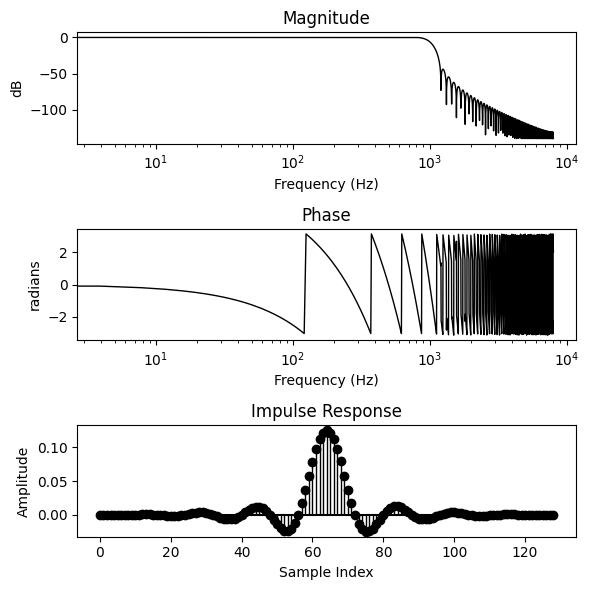

In [439]:
h = get_sinc_lowpass_ir(1000, 64, SAMPLE_RATE)
bode_plot(h, N=4096)

We can then simply get a high pass filter by subtracting the low pass filter from the full band sinc function. This technique is also known as *spectral inversion*.

In [406]:
def get_sinc_highpass_ir(
    cutoff_frequency_hz: Union[float, torch.Tensor],
    ir_length: int,
    sample_rate: float = SAMPLE_RATE,
    window_fn: Callable = torch.hann_window
):
    lowpass_ir = get_sinc_lowpass_ir(cutoff_frequency_hz, ir_length, sample_rate, torch.ones)
    L = ir_length * 2 + 1
    n = torch.arange(L) - ir_length

    fullband_sinc = torch.sinc(n)

    h_hat = fullband_sinc - lowpass_ir
    
    window = window_fn(L)

    return h_hat * window

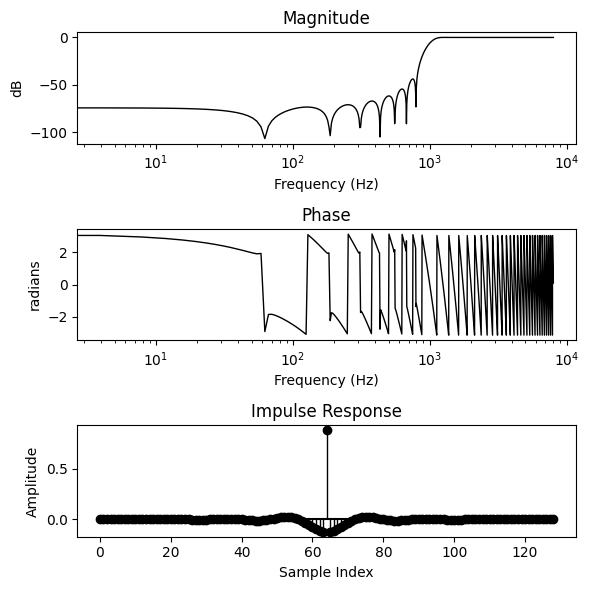

In [407]:
h = get_sinc_highpass_ir(1000, 64, SAMPLE_RATE)
bode_plot(h, N=4096)

Let's define a task to test out these filters... We will create a signal that contains a mixture of frequency components, and optimise the filters to extract just one.

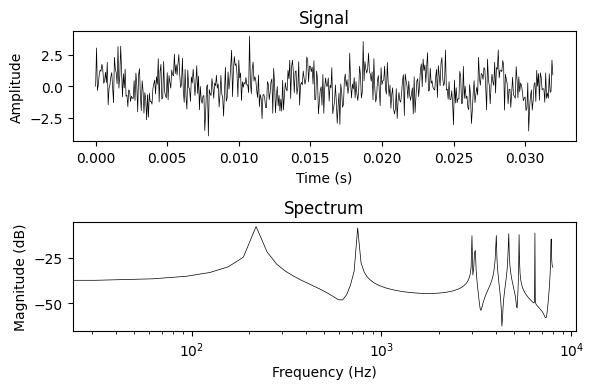

In [447]:
N = 512
num_components = 10
freqs = torch.empty(num_components).uniform_(0, torch.pi)
amps = torch.empty(num_components).uniform_(0, 1)
n = torch.arange(N)
components = amps[:, None] * torch.sin(freqs[:, None] * n[None])

input_signal = components.sum(dim=0)

plot_signal_and_spectrum(input_signal)

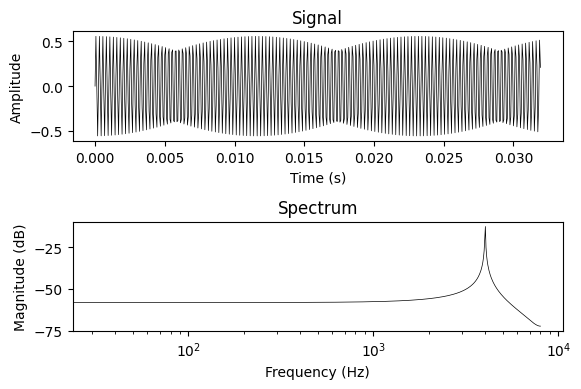

In [448]:
target_signal = components[0]
plot_signal_and_spectrum(target_signal)

In [459]:
low_pass

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

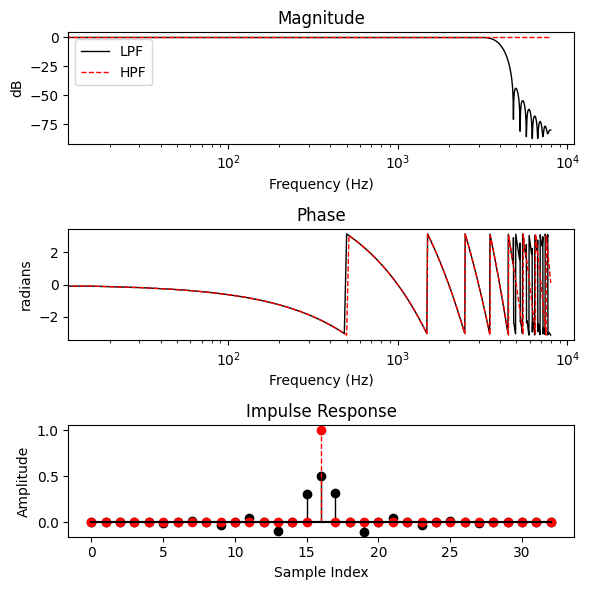

In [494]:
low_pass_cutoff = torch.tensor(SAMPLE_RATE / 4, requires_grad=True)
high_pass_cutoff = torch.tensor(0.0, requires_grad=True)

ir_length = 16

low_pass = get_sinc_lowpass_ir(low_pass_cutoff.detach(), ir_length)
high_pass = get_sinc_highpass_ir(high_pass_cutoff.detach(), ir_length)

bode_plot([low_pass, high_pass], 1024, labels=["LPF", "HPF"])

In [495]:
def fft_loss(a: torch.Tensor, b: torch.Tensor):
    A = torch.fft.rfft(a).abs()
    B = torch.fft.rfft(b).abs()

    return nn.functional.l1_loss(A, B)

In [496]:
optimizer = torch.optim.Adam([low_pass_cutoff, high_pass_cutoff], lr=1e-3)
criterion = fft_loss

steps = 20000
interval = 1000

for step in range(steps):
    low_pass_ir = get_sinc_lowpass_ir(low_pass_cutoff, ir_length)
    high_pass_ir = get_sinc_highpass_ir(high_pass_cutoff, ir_length)

    predicted_signal = apply_conv1d_fir(input_signal, low_pass_ir)
    # predicted_signal = apply_fft_fir(predicted_signal, high_pass_ir)
    
    loss = criterion(target_signal, predicted_signal)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if step % interval == 0:
        print(f"Step {step}: loss {loss.item():.4f}")

Step 0: loss 5.1294
Step 1000: loss 5.1279
Step 2000: loss 5.1265
Step 3000: loss 5.1250


KeyboardInterrupt: 

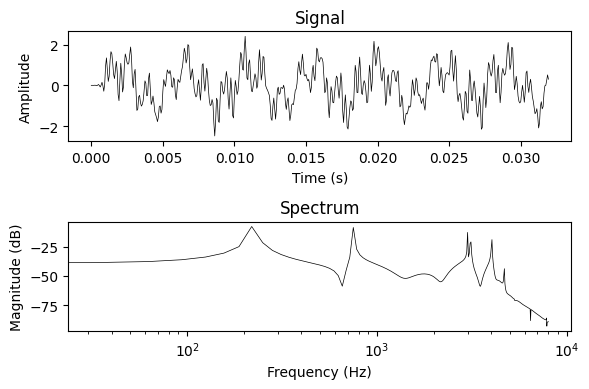

In [488]:
plot_signal_and_spectrum(predicted_signal)